In [1]:
import os
import yaml
import importlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2022-02-08 14:57:27.343916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc10-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc10-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc10-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/l

In [2]:
### Parameters of the training ###

split = "even" 
#split = "odd" 
# split = even | odd -> on what split to train the model (will be in the name)
# -> you need one "odd" and one "even" models to be put inside bamboo

suffix = 'test'
# Suffix that will be added to the saved model (so multiple DNNs can be trained)

quantile = 0.95 # We will repeat the part of the weights rightmost tail
# Eg : 0.95, means we take the 5% events on the right tail of training weight and repeat them
# 1.0 means no correction (to be used if you want to diable it)

# DNN hyperparameters #
parameters = {
    'epochs'                : 200,
    'lr'                    : 0.001,
    'batch_size'            : 256,
    'n_layers'              : 3,
    'n_neurons'             : 64,
    'hidden_activation'     : 'relu',
    'output_activation'     : 'sigmoid',
    'l2'                    : 1e-6,
    'dropout'               : 0.,
    'batch_norm'            : True,
}
# L2 is an additional term in the loss function : l2 x ||W||**2 where ||W|| is the sum of all the DNN weights 
#    inside the neurons
# -> when overfitting the weights take large values, this tells the optimizer the trade off between performances
#    and generalization (from experience, a small value always helps)
# Dropout is a frequency of killing neurons at each batch (no backprogation for them)
# -> used generally when overfitting is detected, to avoid that the DNN learns too much 
#    (from experience, not always useful, put it when you see overfitting)
# Batch normalization is a layer that normalizes the output of each neuron (see documentation)
# -> usually helps that the gradient does not go too far and backprogation is always smooth (supposedly)
#    (from experience : always used it, maybe not worth all the time)


# Input variables
input_vars=["Eta_ph1",
            "Phi_ph1",
            "E_mGG_ph1",
            "pT_mGG_ph1",
            "Eta_ph2",
            "Phi_ph2",
            "E_mGG_ph2",
            "pT_mGG_ph2",
            "deltaPhi_DiPh",
            "deltaR_DiPh",
            "nJets",
            "nBJets",
            "bJet1_pt",
            "bJet1_eta",
            "bJet1_phi",
            "bJet1_E",
            "bJet2_pt",
            "bJet2_eta",
            "bJet2_phi",
            "bJet4_E",
            "E_jet1",   
            "pT_jet1",
            "Eta_jet1",
            "Phi_jet1", 
            "E_jet2",   
            "pT_jet2",
            "Eta_jet2",
            "Phi_jet2",  
            "E_jet3",   
            "pT_jet3",
            "Eta_jet3",
            "Phi_jet3",
            "E_jet4",   
            "pT_jet4",
            "Eta_jet4",
            "Phi_jet4",
            "w1_pT",
            "w1_eta",
            "w1_mass",
            "w2_pT",
            "w2_eta",
            "w2_mass",
            "ww_pT",
            "ww_eta",
            "ww_mass",
            "mindeltaRPJ",
            "maxdeltaRPJ",
            "deltaRJJ",
            "deltaRJJ2",
            "deltaPhi_HH",
            "deltaR_HH"]

In [3]:
# Load the required data #
outputPath = '/home/ucl/cp3/sdonerta/bamboodev/WWGG/FH_Skim_08_02'
skimFile = os.path.join(outputPath,'results','Skim_FH.parquet')
yamlFile = os.path.join(outputPath,'plots.yml')

# Load dataframe from parquet #
df = pd.read_parquet(skimFile)

# Load samples + plots data from yaml file #
with open(yamlFile,'r') as handle:
    config = yaml.load(handle)


/nfs/scratch/fynu/sdonerta/ipykernel_3784823/405900529.py:11: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(handle)


In [4]:
# Cut negative event weights #
df = df[(df['weight']>0) & (df['weight']<300)]
#df = df[df['weight']>0]

# Cut events/samples #
df = df[~df.process.str.contains("GluGluToHHTo2B2G")]
df = df[~df.process.str.contains("GluGluToHHTo2G2Tau")]
df = df[~df.process.str.contains("GluGluToHHTo2G2l2nu")]
df = df[~df.process.str.contains("GluGluToHHTo2G2Qlnu")]
df = df[~df.process.str.contains("VBF")]
df = df[~df.process.str.contains("GluGluHToGG")]
df = df[~df.process.str.contains("ttH")]
df = df[~df.process.str.contains("VH")]
df = df[~df.process.str.contains("THQ")]
df = df[~df.process.str.contains("W1")]
df = df[~df.process.str.contains("W2")]
df = df[~df.process.str.contains("W3")]
df = df[~df.process.str.contains("WGJJ")]
df = df[~df.process.str.contains("WGGJets")]
df = df[~df.process.str.contains("DY")]
df = df[~df.process.str.contains("ZG")]
df = df[~df.process.str.contains("WW_TuneCUETP8M")]
df = df[~df.process.str.contains("TT_TuneCUETP8M2T4")]
df = df[~df.process.str.contains("TTWJetsToLNu")]

for i in df.process.unique():
    print(i)


GluGluToHHTo2G4Q_node_cHHH1_TuneCP5_14TeV-powheg-pythia8_200PU.root
DiPhotonJetsBox_MGG-80toInf_14TeV-Sherpa_200PU.root
DiPhotonJetsBox_MGG-40to80_14TeV-Sherpa_200PU.root
GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUEP8M2T4_14TeV_Pythia8_200PU.root
GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_14TeV-pythia8_200PU.root
TTGJets_TuneCP5_14TeV-amcatnloFXFX-madspin-pythia8_200PU.root
TTGG_0Jets_TuneCUETP8M1_14TeV_amcatnlo_madspin_pythia8_200PU.root


In [5]:
# Set labels #
df["label"] = 0
for process in pd.unique(df['process']):
    if process not in config['files']:
        raise RuntimeError(f'Process {process} not found in yaml config file')
    if config['files'][process]['type'] == 'signal':
        df.loc[df['process']==process, ['label']] = 1
        
df.loc[df.process.str.contains("2B2G"), ['label']] = 0

In [6]:
print(df)

         weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2  \
0      0.000030  0.942690  2.527667   2.548837    1.724252  0.422261   
1      0.000030 -1.244896  2.048930   1.352316    0.719213 -0.060764   
2      0.000030  1.010932  1.825873   1.214807    0.780714  1.823165   
3      0.000030 -2.143009  2.289106   4.609327    1.066683 -2.149474   
4      0.000030 -0.268440  1.030220   1.015852    0.980319  0.796547   
...         ...       ...       ...        ...         ...       ...   
29122  0.094104  0.281171 -1.705639   0.490953    0.472166  2.070043   
29123  0.094104  1.126852 -1.739080   0.608107    0.356663 -1.054434   
29124  0.094104 -1.425753  0.464851   2.222521    1.009934 -1.478961   
29125  0.094104  0.792445 -0.181425   0.878423    0.660090 -0.271204   
29126  0.094104 -0.975030  2.091275   1.464749    0.967333 -0.846210   

        Phi_ph2  E_mGG_ph2  pT_mGG_ph2  deltaPhi_DiPh  ...    ww_eta  \
0      1.045841   0.301261    0.276263      -1.481826  ...  2.5

In [7]:
# Produce physical event weight #
# df['event_weight'] = pd.Series(np.zeros(df.shape[0]))
# lumi = config['configuration']['luminosity']['HL-LHC']
# for process in pd.unique(df['process']):
#     print (f'Looking at process {process}')
#     if 'cross-section' in config['files'][process].keys() and config['files'][process]['type'] != 'signal':
#         cross_section = config["files"][process]["cross-section"]
#     else:
#         cross_section = 1.
#         # For signal, we assume unit cross section (otherwise significance can be too unstable)
#     if 'branching-ratio' in config['files'][process].keys():
#         BR = config["files"][process]["branching-ratio"]
#     else:
#         BR = 1
#     if 'generated-events' in config['files'][process].keys():
        
#         generated_events = config["files"][process]["generated-events"]
#     else:
#         raise RuntimeError('Process {process} is missing `generated-events` entry, should not happen')
        
#     print (f'... cross-section = {cross_section}')
#     print (f'... branching-ratio = {BR}')
#     print (f'... generated-events = {generated_events}')
#     factor = lumi * cross_section * BR / generated_events
#     # We don't really care about luminosity because the scale of the weights do not matter, and you have a single lumi
#     print (f'   -> Total factor = {factor}')
#     # Apply to the new event_weight columns #
#     df.loc[df["process"]==process,'event_weight'] = df[df["process"]==process]['weight'] * factor
#     print (f'   Sum of weights = {df[df["process"]==process]["weight"].sum()} -> {df[df["process"]==process]["event_weight"].sum()}')

df['event_weight'] = df['weight'].copy()

if (df['event_weight'] < 0).sum() > 0:
    raise RuntimeError(f"There are {(df['event_weight'] < 0).sum()} events with negative event weight, this should not happen")

In [8]:
# Compute training weight #
if 'training_weight' in df.columns:
    del df['training_weight']
df['training_weight'] = df['event_weight'].copy()

df.loc[df['label']==1,'training_weight'] *= df.shape[0]/2 / (df[df['label']==1]['event_weight']).sum()
df.loc[df['label']==0,'training_weight'] *= df.shape[0]/2 / (df[df['label']==0]['event_weight']).sum()

#df = df[df['training_weight']<500]

for i in df.process.unique():
    print(i)
 

GluGluToHHTo2G4Q_node_cHHH1_TuneCP5_14TeV-powheg-pythia8_200PU.root
DiPhotonJetsBox_MGG-80toInf_14TeV-Sherpa_200PU.root
DiPhotonJetsBox_MGG-40to80_14TeV-Sherpa_200PU.root
GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUEP8M2T4_14TeV_Pythia8_200PU.root
GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_14TeV-pythia8_200PU.root
TTGJets_TuneCP5_14TeV-amcatnloFXFX-madspin-pythia8_200PU.root
TTGG_0Jets_TuneCUETP8M1_14TeV_amcatnlo_madspin_pythia8_200PU.root


In [9]:
import utils
importlib.reload(utils) # Reload in case file has changed
print ('Using event weight')
utils.checkBatches(df,weight_column='event_weight',batch_size=parameters['batch_size'])
print ('Using training weight')
utils.checkBatches(df,weight_column='training_weight',batch_size=parameters['batch_size'])

Using event weight
On average, per batch the total learning weight is
	... signal     :     0.004020549 [134.26 events]
	... background :   482.700145874 [121.74 events]
Using training weight
On average, per batch the total learning weight is
	... signal     :   128.167882538 [134.98 events]
	... background :   127.696516953 [121.02 events]


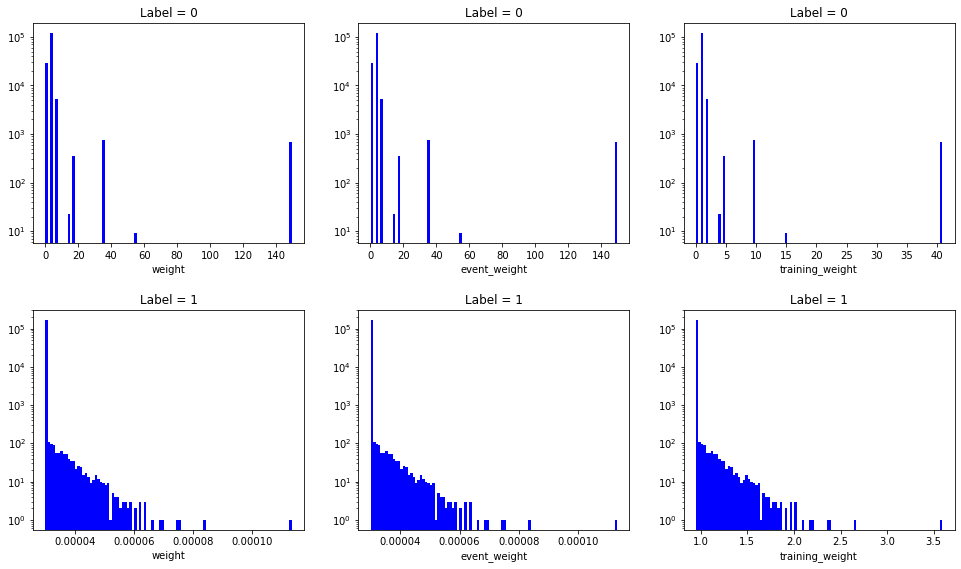

In [10]:
# Plot the background and signal weights #
fig,axs = plt.subplots(figsize=(16,8),nrows=2,ncols=3)
fig.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.1, wspace=0.2,hspace=0.3)
for irow,label in enumerate([0,1]):
    for icol,column in enumerate(['weight','event_weight','training_weight']):
        axs[irow,icol].hist(df[df['label']==label][column],bins=100,color='b')
        axs[irow,icol].set_title(f"Label = {label}")
        axs[irow,icol].set_xlabel(column)
        axs[irow,icol].set_yscale('log')
fig.savefig("event_weights_A.pdf", dpi = 300)


In [11]:
# Plot the weights per process #
if False:
    with PdfPages("event_weights_B.pdf") as pdf:
        for process in pd.unique(df['process']):
            fig,axs = plt.subplots(figsize=(16,6),nrows=1,ncols=3)
            fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2,hspace=0.3)
            fig.suptitle(f"Process {process}")
            for icol,column in enumerate(['weight','event_weight','training_weight']):
                axs[icol].hist(df[df['process']==process][column],bins=100,color='b')
                axs[icol].set_xlabel(column)
                axs[icol].set_xlim(0,(df[df['process']==process][column]).max()*1.5)
                axs[icol].set_yscale('log')
            pdf.savefig()
            plt.close(fig)

In [12]:
print(df[input_vars])

        Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0      0.942690  2.527667   2.548837    1.724252  0.422261  1.045841   
1     -1.244896  2.048930   1.352316    0.719213 -0.060764 -1.818675   
2      1.010932  1.825873   1.214807    0.780714  1.823165 -2.318186   
3     -2.143009  2.289106   4.609327    1.066683 -2.149474 -2.856926   
4     -0.268440  1.030220   1.015852    0.980319  0.796547  1.571576   
...         ...       ...        ...         ...       ...       ...   
29122  0.281171 -1.705639   0.490953    0.472166  2.070043 -0.652895   
29123  1.126852 -1.739080   0.608107    0.356663 -1.054434  2.041647   
29124 -1.425753  0.464851   2.222521    1.009934 -1.478961 -2.700558   
29125  0.792445 -0.181425   0.878423    0.660090 -0.271204 -2.775463   
29126 -0.975030  2.091275   1.464749    0.967333 -0.846210 -2.411030   

       E_mGG_ph2  pT_mGG_ph2  deltaPhi_DiPh  deltaR_DiPh  ...     w2_mass  \
0       0.301261    0.276263      -1.481826     1.570559  

In [13]:
# Determine splitting variable #
split_var = df['Phi_ph1'].copy()
split_var *= 1e4
split_var -= np.floor(split_var) 
split_var = (split_var*1e1).astype(int)
split_var = split_var %2 == 0
print (f'Even set has {df[split_var].shape[0]:10d} events [{df[split_var].shape[0]/df.shape[0]*100:5.2f}%]')
print (f'Odd  set has {df[~split_var].shape[0]:10d} events [{df[~split_var].shape[0]/df.shape[0]*100:5.2f}%]')

Even set has     165336 events [50.07%]
Odd  set has     164889 events [49.93%]


In [14]:
# Sets splitting #
print (f'Using split type {split}')
# split_var = True (even number) | False (odd number)
# Name of the model is related to the even | odd quality of the events during inference (ie, in bamboo)
if split == 'even':
    train_df = df[~split_var] # Trained on odd
    test_df  = df[split_var]  # Evaluated on even 
elif split == 'odd':
    train_df = df[split_var]  # Trained on even
    test_df  = df[~split_var] # Evaluated on odd 
else:
    raise RuntimeError(f'Split needs to be either odd or even, is {split}')

# Randomize for training (always good to randomize) #
train_df = train_df.sample(frac=1)

# Quantile corrections #
# When an event has a large weight, it can imbalance a lot the training, still the weight might have a meaning
# Idea : instead of 1 event with wi>>1, we use N copies of the event with wf = wi/N
# From the point of view of the physics it does not matter, the total event weight sum of each process is the same
# From the point of view of the DNN, we have split a tough nut to crack into several smaller ones

quantile_lim = train_df['training_weight'].quantile(quantile)
print (f'{(1-quantile)*100:5.2f}% right quantile is when weight is at {quantile_lim}')
print ('  -> These events will be repeated and their learning weights reduced accordingly to avoid unstability') 

# Select the events #
idx_to_repeat = train_df['training_weight'] >= quantile_lim                          
events_excess = train_df[idx_to_repeat].copy()

saved_columns = train_df[['training_weight','process']].copy()

# Compute multiplicative factor #
factor = (events_excess['training_weight']/quantile_lim).values.astype(np.int32) 

# Correct the weights of events already in df #
train_df.loc[idx_to_repeat,'training_weight'] /= factor

# Add N-1 copies #
arr_to_repeat = train_df[idx_to_repeat].values                                       
repetition = np.repeat(np.arange(arr_to_repeat.shape[0]), factor-1)                   
df_repeated = pd.DataFrame(np.take(arr_to_repeat,repetition,axis=0),columns=train_df.columns)
df_repeated = df_repeated.astype(train_df.dtypes.to_dict()) # otherwise dtypes are object
train_df = pd.concat((train_df,df_repeated),axis=0,ignore_index=True).sample(frac=1).reset_index() # Add and randomize

# Printout #
print ('Changes per process in training set')
for process in pd.unique(train_df['process']):
    N_before = saved_columns[saved_columns['process']==process].shape[0]
    N_after  = train_df[train_df['process']==process].shape[0]
    if N_before != N_after:
        print (f"{process:20s}")
        print (f"... {N_before:6d} events [sum weight = {saved_columns[saved_columns['process']==process]['training_weight'].sum():14.6f}]",end=' -> ')
        print (f"{N_after:6d} events [sum weight = {train_df[train_df['process']==process]['training_weight'].sum():14.6f}]")
    
print ()
print (f"Total entries : {saved_columns.shape[0]:14d} -> {train_df.shape[0]:14d}")
print (f"Total event sum : {saved_columns['training_weight'].sum():14.6f} -> {train_df['training_weight'].sum():14.6f}")

# Validation split #
train_df,val_df  = train_test_split(train_df,test_size=0.3)

# Printout #
print ('\nFinal sets')
print (f'Training set   = {train_df.shape[0]}')
print (f'Validation set = {val_df.shape[0]}')
print (f'Testing set    = {test_df.shape[0]}')
print (f'Total set      = {df.shape[0]}')

Using split type even
 5.00% right quantile is when weight is at 1.057970643043518
  -> These events will be repeated and their learning weights reduced accordingly to avoid unstability
Changes per process in training set
GluGluToHHTo2G4Q_node_cHHH1_TuneCP5_14TeV-powheg-pythia8_200PU.root
...  86770 events [sum weight =   82405.265625] ->  86774 events [sum weight =   82405.265625]
GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUEP8M2T4_14TeV_Pythia8_200PU.root
...    344 events [sum weight =   14052.233398] ->  13072 events [sum weight =   14052.232422]
DiPhotonJetsBox_MGG-80toInf_14TeV-Sherpa_200PU.root
...  53671 events [sum weight =   57309.507812] ->  57205 events [sum weight =   57309.500000]
DiPhotonJetsBox_MGG-40to80_14TeV-Sherpa_200PU.root
...    495 events [sum weight =     993.994263] ->    535 events [sum weight =     993.994324]
GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_14TeV-pythia8_200PU.root
...      5 events [sum weight =      74.711395] ->     70 events [

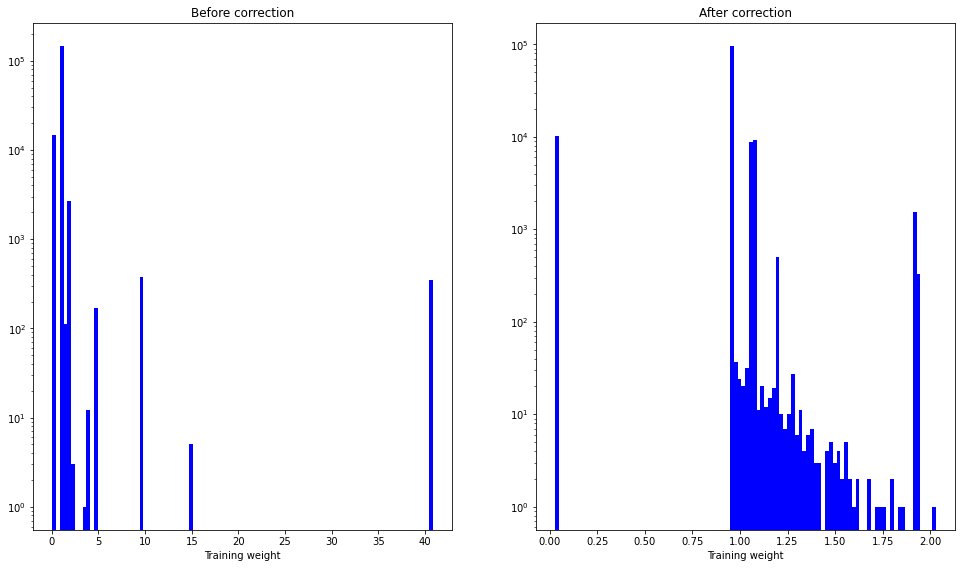

In [15]:
# Plot the background and signal weights #
fig,axs = plt.subplots(figsize=(16,8),nrows=1,ncols=2)
fig.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.1, wspace=0.2,hspace=0.3)

if split == 'even':
    axs[0].hist(df[~split_var]['training_weight'],bins=100,color='b')
elif split == 'odd':
    axs[0].hist(df[split_var]['training_weight'],bins=100,color='b')
axs[0].set_title("Before correction")
axs[0].set_xlabel("Training weight")
axs[0].set_yscale('log')
axs[1].hist(train_df['training_weight'],bins=100,color='b')
axs[1].set_title("After correction")
axs[1].set_xlabel("Training weight")
axs[1].set_yscale('log')
fig.savefig("event_weights_C.pdf", dpi = 300)

In [16]:
# Input layer #
inputs = keras.Input(shape=(len(input_vars),), name="particles")

# Preprocessing layer
from tensorflow.keras.layers.experimental import preprocessing
normalizer = preprocessing.Normalization(mean     = train_df[input_vars].mean(axis=0),
                                         variance = train_df[input_vars].var(axis=0),
                                         name     = 'Normalization')(inputs)
    # this layer does the preprocessing (x-mu)/std for each input
# Dense (hidden) layers #
x = normalizer
for i in range(parameters['n_layers']):
    x = layers.Dense(units                = parameters['n_neurons'], 
                     activation           = parameters['hidden_activation'], 
                     activity_regularizer = tf.keras.regularizers.l2(parameters['l2']),
                     name                 = f"dense_{i}")(x)
    if parameters['batch_norm']:
        x = layers.BatchNormalization()(x)
    if parameters['dropout'] > 0.:
        x = layers.Dropout(parameters['dropout'])(x)
# Output layer #
outputs = layers.Dense(units                = 1, 
                       activation           = parameters['output_activation'],
                       activity_regularizer = tf.keras.regularizers.l2(parameters['l2']),
                       name                 = "predictions")(x)

# Registering the model #
model = keras.Model(inputs=inputs, outputs=outputs)

2022-02-08 14:58:13.191424: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc10-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc10-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc10-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lcg/views/L

In [17]:
model_preprocess = keras.Model(inputs=inputs, outputs=normalizer)
out_test = model_preprocess.predict(train_df[input_vars],batch_size=5000)
print ('Input (after normalization) mean (should be close to 0)')
print (out_test.mean(axis=0))
print ('Input (after normalization) variance (should be close to 1)')
print (out_test.var(axis=0))

2022-02-08 14:58:14.027329: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-08 14:58:14.268310: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2394070000 Hz


Input (after normalization) mean (should be close to 0)
[ 1.3543307e-08  2.0592122e-08  9.6386259e-09 -5.2489007e-08
  9.2813695e-09  1.7387389e-08 -1.1600362e-08  1.8524219e-08
  2.1546331e-09  2.1005044e-07  1.0202174e-06  5.2217695e-07
  1.9823540e-07 -1.2401406e-07 -2.7518247e-06  1.0484948e-06
 -8.7226158e-07  2.0037157e-06  5.5263132e-07  1.4196421e-07
 -8.5709218e-08  1.0592388e-07  1.8320341e-08  1.3287756e-08
  4.7948618e-08  1.6143147e-07  2.4127098e-09  1.8367787e-08
  4.1061870e-08 -1.5909652e-07  1.7658444e-09  3.9013931e-10
 -2.4284940e-08 -6.1776127e-08 -4.2466700e-10  4.5473193e-08
  1.8771033e-07  1.2087507e-08 -8.6835243e-08  3.3151647e-07
 -3.7043741e-08  2.3552108e-08 -1.6145003e-07 -9.2130188e-09
  7.7770430e-08 -8.1381986e-09  1.7307999e-08  5.7878729e-08
  7.6797079e-08 -5.1995400e-08 -2.3320231e-07]
Input (after normalization) variance (should be close to 1)
[0.9999899  0.99997187 0.99995774 0.9999846  0.99996865 0.99998015
 0.9999693  0.9999653  0.99998933 0.99

In [18]:
model.compile(
    #optimizer=keras.optimizers.RMSprop(),
    optimizer=keras.optimizers.Adam(lr=parameters['lr']),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
particles (InputLayer)       [(None, 51)]              0         
_________________________________________________________________
Normalization (Normalization (None, 51)                103       
_________________________________________________________________
dense_0 (Dense)              (None, 64)                3328      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160  

/cvmfs/sft.cern.ch/lcg/views/LCG_101/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
# Callbacks #
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.001, 
                               patience = 20,
                               verbose=1,
                               mode='min',
                               restore_best_weights=True)
# Stop the learning when val_loss stops increasing 
# https://keras.io/api/callbacks/early_stopping/

reduce_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                                   factor = 0.1,
                                   min_delta = 0.001, 
                                   patience = 8,
                                   min_lr = 1e-8,
                                   verbose=2,
                                   mode='min')
# reduce LR if not improvement for some time 
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
import History 
importlib.reload(History)
loss_history = History.LossHistory()

In [20]:
history = model.fit(
    train_df[input_vars],
    train_df['label'],
    verbose=2,
    batch_size=parameters['batch_size'],
    epochs=parameters['epochs'],
    sample_weight=train_df['training_weight'],
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(val_df[input_vars],val_df['label'],val_df['training_weight']),
    callbacks = [early_stopping, reduce_plateau, loss_history],
)


Epoch 1/200
496/496 - 9s - loss: 0.3836 - binary_accuracy: 0.8067 - auc: 0.8830 - precision: 0.8047 - recall: 0.7878 - val_loss: 0.3556 - val_binary_accuracy: 0.8222 - val_auc: 0.8969 - val_precision: 0.8231 - val_recall: 0.7992
Epoch 2/200
496/496 - 3s - loss: 0.3469 - binary_accuracy: 0.8277 - auc: 0.9037 - precision: 0.8272 - recall: 0.8097 - val_loss: 0.3473 - val_binary_accuracy: 0.8287 - val_auc: 0.9026 - val_precision: 0.8285 - val_recall: 0.8087
Epoch 3/200
496/496 - 3s - loss: 0.3349 - binary_accuracy: 0.8347 - auc: 0.9101 - precision: 0.8340 - recall: 0.8179 - val_loss: 0.3421 - val_binary_accuracy: 0.8303 - val_auc: 0.9052 - val_precision: 0.8412 - val_recall: 0.7945
Epoch 4/200
496/496 - 3s - loss: 0.3280 - binary_accuracy: 0.8378 - auc: 0.9135 - precision: 0.8371 - recall: 0.8216 - val_loss: 0.3438 - val_binary_accuracy: 0.8306 - val_auc: 0.9038 - val_precision: 0.8354 - val_recall: 0.8034
Epoch 5/200
496/496 - 3s - loss: 0.3225 - binary_accuracy: 0.8404 - auc: 0.9161 - pr

Curves saved as loss_test_even.png


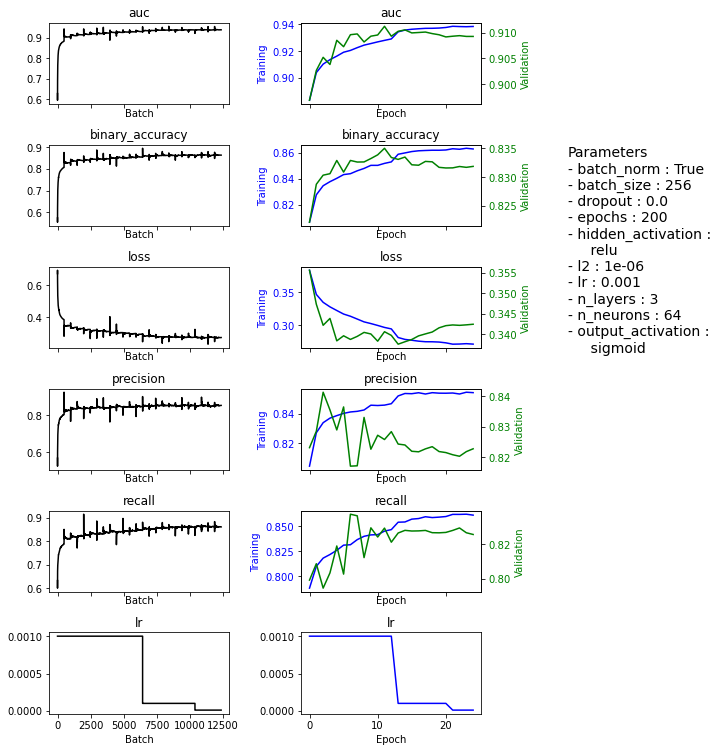

In [21]:
History.PlotHistory(loss_history,params=parameters,outputName=f'loss_{suffix}_{split}.png')
# Params is a dict of parameters with name and values
# used for plotting


In [22]:
# Produce output on the test set as new column #
output = model.predict(test_df[input_vars],batch_size=5000)
    # Here the batch_size arg is independent of the learning
    # Default is 32, but it can become slow, by using large value it will just compute more values in parallel
    # (more or less parallel, we are not using a GPU)
if 'output' in test_df.columns:
    # If already output, need to remove to add again
    # avoid issues in case you run this cell multiple times
    del test_df['output']
test_df = pd.concat((test_df,pd.DataFrame(output,columns=['output'],index=test_df.index)),axis=1)
# We add the output as a column, a bit messy, different ways, here I use a concatenation

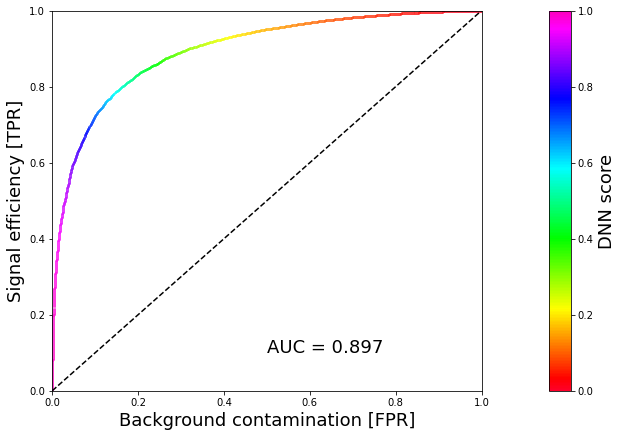

Saved ROC as roc_test_even.pdf
Best WP based on significance = 0.97861


In [23]:
import roc
importlib.reload(roc) # Reload in case file has changed
roc.rocAndSig(y_true     = test_df['label'],
              y_pred     = test_df['output'],
              w_roc      = test_df['training_weight'],
              w_sig      = test_df['event_weight'],
              outputName = f'roc_{suffix}_{split}.pdf')


No handles with labels found to put in legend.
No handles with labels found to put in legend.


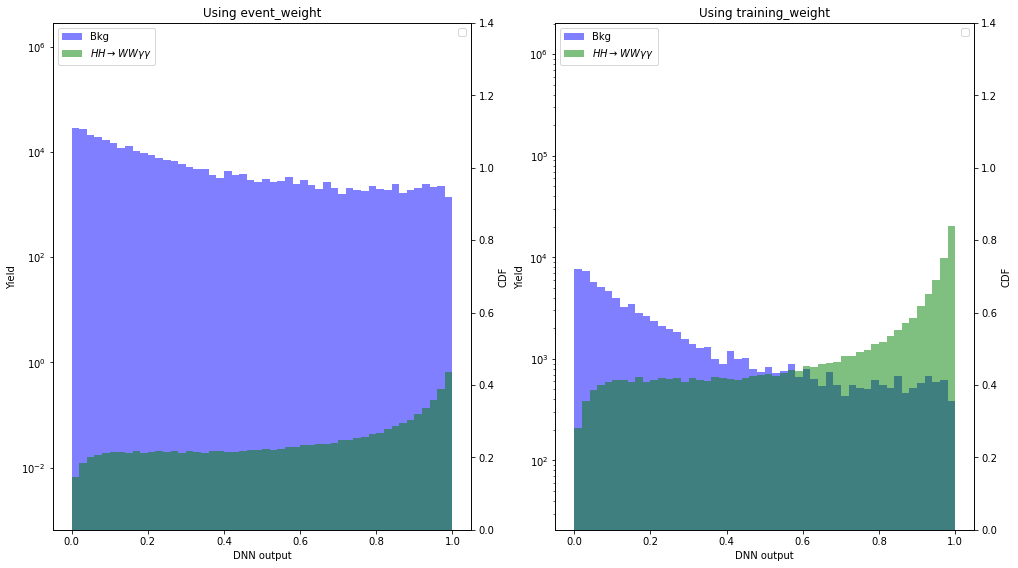

In [24]:
fig,axs = plt.subplots(figsize=(16,8),nrows=1,ncols=2)
fig.subplots_adjust(left=0.1, right=0.9, top=0.98, bottom=0.1, wspace=0.2,hspace=0.3)

sig_df = test_df[test_df['label']==1]
bkg_df = test_df[test_df['label']==0]

# Manual binning so we can compute significance #
bins = np.linspace(0,1,51)
centers = (bins[1:]+bins[:-1])/2
widths = np.diff(bins)


def get_bin_content(y,w):
    digitized = np.digitize(y,bins)
    return np.array([w[digitized==i].sum() for i in range(1, len(bins))])

for icol,weight in enumerate(['event_weight','training_weight']):
    # Fill the bins myself #
    b = get_bin_content(bkg_df['output'],bkg_df[weight])
    s = get_bin_content(sig_df['output'],sig_df[weight])
    cumsum_s_left = np.cumsum(s)/s.sum()
    cumsum_b_left = np.cumsum(b)/b.sum()
    cumsum_s_right = np.cumsum(s[::-1])[::-1]/s.sum()
    cumsum_b_right = np.cumsum(b[::-1])[::-1]/b.sum()
    # Need to integrate all the bins right of the DNN cut to get significance
    z_left = np.nan_to_num(np.sqrt(2*((cumsum_s_left+cumsum_b_left)*np.log(1+cumsum_s_left/cumsum_b_left)-cumsum_s_left)))
    z_right = np.nan_to_num(np.sqrt(2*((cumsum_s_right+cumsum_b_right)*np.log(1+cumsum_s_right/cumsum_b_right)-cumsum_s_right)))
    z_left /= z_left.max()
    z_right /= z_right.max()
    axs[icol].bar(x=centers,height=b,width=widths,alpha=0.5,color='b',label='Bkg')
    axs[icol].bar(x=centers,height=s,width=widths,alpha=0.5,color='g',label=r'$HH \rightarrow WW \gamma \gamma$')
    ax2=axs[icol].twinx()   
#     ax2.plot(centers,z_left,color='r',label='Significance (left of cut) [normed]')
#     ax2.plot(centers,cumsum_s_left,color='g',label='Signal content (left of cut)')
#     ax2.plot(centers,cumsum_b_left,color='b',label='Bkg content (left of cut)')
#     ax2.plot(centers,z_right,color='r',linestyle='--',label='Significance (right of cut) [normed]')
#     ax2.plot(centers,cumsum_s_right,color='g',linestyle='--',label='Signal content (right of cut)')
#     ax2.plot(centers,cumsum_b_right,color='b',linestyle='--',label='Bkg content (right of cut)')
    #ax2.set_yscale("log")
    #ax2.set_ylim([0,z.max()*1.1])
    ax2.set_ylim([0,1.4])
    ax2.set_ylabel('CDF')
    ax2.legend(loc='upper right')

    axs[icol].set_title(f"Using {weight}")
    axs[icol].set_xlabel('DNN output')
    axs[icol].set_ylabel('Yield')
    axs[icol].set_ylim([s.min()*0.1,np.maximum(s,b).max()*100])
    axs[icol].set_yscale('log')
    axs[icol].legend(loc='upper left')
fig.savefig(f"prediction_{suffix}_{split}.pdf", dpi = 300)



In [25]:
# evaluate the model
scores = model.evaluate(test_df[input_vars], 
                        test_df['label'], 
                        sample_weight = test_df['training_weight'], 
                        batch_size = 5000,
                        verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

34/34 - 0s - loss: 0.4121 - binary_accuracy: 0.8206 - auc: 0.9002 - precision: 0.8366 - recall: 0.8194
binary_accuracy: 82.06%


In [26]:
# save model and architecture to single file
modelName = f"model_{suffix}_{split}"
model.save(modelName)
print(f"Saved model to disk as {modelName}")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-02-08 15:02:11.070973: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: model_test_even/assets
Saved model to disk as model_test_even
